In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [2]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 33% 5.00M/15.1M [00:00<00:00, 50.5MB/s]
100% 15.1M/15.1M [00:00<00:00, 111MB/s] 


In [3]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

<ipython-input-3-b832699befdd>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [4]:
from tensorflow.keras.applications import EfficientNetB0

Done


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,887,141 (22.46 MB)

 Trainable params: 1,837,570 (7.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5917 - loss: 0.6809 - val_accuracy: 0.6071 - val_loss: 0.6752 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.6552 - loss: 0.6696 - val_accuracy: 0.6071 - val_loss: 0.6799 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5617 - loss: 0.6909 - val_accuracy: 0.6071 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.6853 - loss: 0.6925 - val_accuracy: 0.6071 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5241 - loss: 0.7073 - val_accuracy: 0.3929 - val_loss: 0.7033 - learning_rate: 0.0010
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.5040 - loss: 0.6941 - val_accuracy: 0.6071 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6133 - loss: 0.7076 - val_accuracy: 0.6071 - val_loss: 0.6821

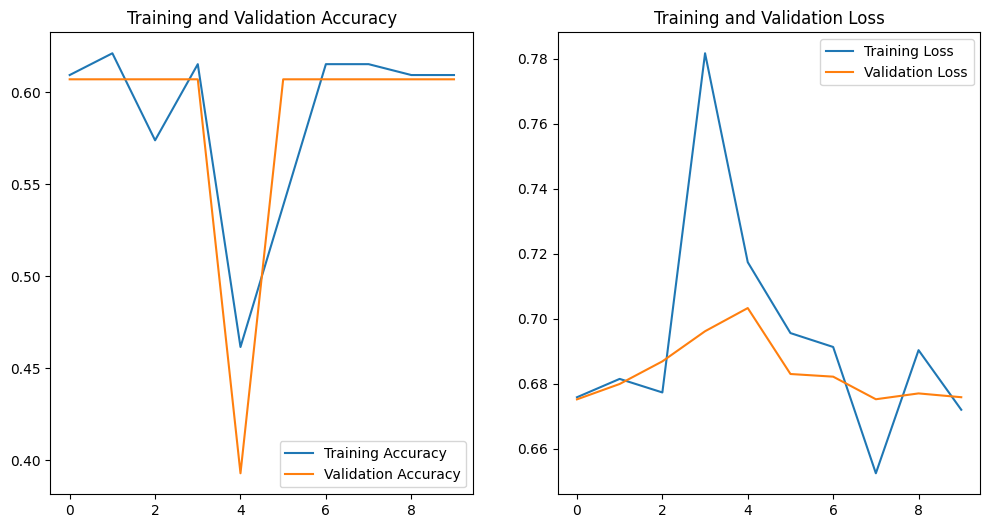

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 98s 9s/step - accuracy: 0.6131 - loss: 1.2319 - val_accuracy: 0.6071 - val_loss: 0.6834 - learning_rate: 1.0000e-05
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 75s 7s/step - accuracy: 0.5986 - loss: 1.1951 - val_accuracy: 0.6071 - val_loss: 0.7139 - learning_rate: 1.0000e-05
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.5869 - loss: 0.9893 - val_accuracy: 0.6071 - val_loss: 0.7411 - learning_rate: 1.0000e-05
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 0.5957 - loss: 0.8820 - val_accuracy: 0.6071 - val_loss: 0.7322 - learning_rate: 1.0000e-05
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.6307 - loss: 0.7710 - val_accuracy: 0.6071 - val_loss: 0.7170 - learning_rate: 1.0000e-05
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - accuracy: 0.6427 - loss: 0.7161 - val_accuracy: 0.6071 - val_loss: 0.7006 - learning_rate: 1.0000e-05
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 88s 8s/step - accuracy: 0.5989 - loss: 0.7573 - val_

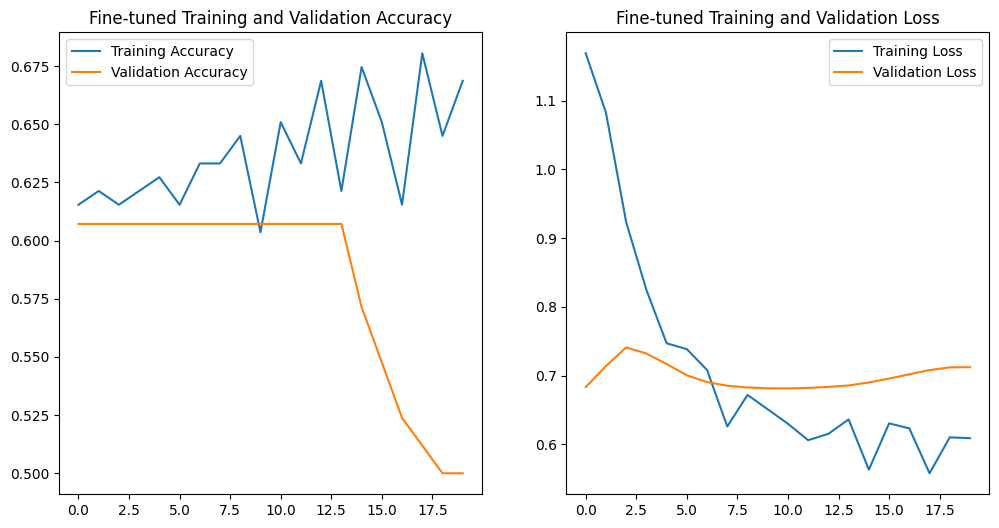

In [6]:
# Unzip the dataset
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

# Load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            img = img / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
            labels.append(label)
    return images, labels

X_yes, y_yes = load_images_from_folder('/content/yes', 'Y')
X_no, y_no = load_images_from_folder('/content/no', 'N')

X = X_yes + X_no
y = y_yes + y_no

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Preprocessing for standardization
def preprocess_input(x):
    return (x - np.mean(x)) / np.std(x)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Apply Gaussian blur as part of preprocessing
def apply_gaussian_blur(images):
    blurred_images = []
    for img in images:
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
        blurred_images.append(blurred_img)
    return np.array(blurred_images)

X_train_blurred = apply_gaussian_blur(X_train)
X_test_blurred = apply_gaussian_blur(X_test)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=apply_gaussian_blur  # Apply Gaussian blur during augmentation
)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Build the EfficientNet model with fine-tuning
def build_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(num_classes=2)
model.summary()

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with data augmentation and learning rate scheduling
history = model.fit(datagen.flow(X_train_blurred, y_train, batch_size=32),
                    validation_data=(X_test_blurred, y_test),
                    epochs=10,
                    callbacks=[lr_scheduler],
                    verbose=1)

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Fine-tune some of the top layers of the EfficientNet model
for layer in model.layers[:20]:  # Adjust the number of layers to unfreeze
    layer.trainable = False
for layer in model.layers[20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the fine-tuned model
fine_tune_history = model.fit(datagen.flow(X_train_blurred, y_train, batch_size=32),
                              validation_data=(X_test_blurred, y_test),
                              epochs=20,
                              callbacks=[lr_scheduler],
                              verbose=1)

# Plot the fine-tuned training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuned Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Fine-tuned Training and Validation Loss')
plt.legend()

plt.show()